In [4]:
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import ast
from gensim.models import KeyedVectors
import nltk
import torch
from ast import literal_eval

Load Data

In [2]:
def load_dataset():
    """
    Load training and test sets
    """
    train = pd.read_csv("./twitter_dataset/train.csv")
    dev = pd.read_csv("./twitter_dataset/dev.csv")
    
    return train, dev

Embed Input

In [3]:
def tokenizer(text: str):
    '''
    Citation: This tokenizer function & regex rule is borrowed from Katie's tokenizer regex demo at:
    https://www.cs.williams.edu/~kkeith/teaching/s23/cs375/attach/tokenization_regex_demo.html
    This helper function takes a string and returns a list of tokenized strings.
    '''
    regex = r"[A-Za-z]+|\$[\d\.]+|\S+" 
    res = nltk.regexp_tokenize(text, regex)
    return [i for i in res if i != "."]

In [8]:
def load_embeddings(filename):
    """
    Loads embeddings from embedding file and creates 
    1) dictionary of embedding words to indices
    2) list of embedding indices to words
    3) dense word embedding matrix
    """
    embeddings = KeyedVectors.load_word2vec_format(filename, binary=False)
    vocab2indx = dict(embeddings.key_to_index)
    idx2vocab = list(embeddings.index_to_key)
    embed_array = embeddings.vectors # matrix of dense word embeddings 
                                     # rows: a word 
                                     # columns: dimensions (50) of the dense embeddings
    return vocab2indx, idx2vocab, embed_array


def add_the_embedding(embed_array, vocab2indx): 
    """
    Adds "the" embedding to the embed_array matrix
    """
    the_embedding = embed_array[vocab2indx["the"]]
    out = np.vstack((embed_array, the_embedding))
    return out


def add_oov(idx2vocab, vocab2indx, embed_array):
    """
    Adds <OOV> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_oov_entry = len(embed_array)
    idx2vocab += ["<OOV>"]
    vocab2indx["<OOV>"] = new_oov_entry
    embed_array_w_oov = add_the_embedding(embed_array, vocab2indx)

    return idx2vocab, vocab2indx, embed_array_w_oov


def add_pad(idx2vocab, vocab2indx, embed_array):
    """
    Adds <PAD> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_pad_entry = len(embed_array)
    idx2vocab += ["<PAD>"]
    vocab2indx["<PAD>"] = new_pad_entry
    embed_array_w_pad = add_the_embedding(embed_array, vocab2indx)
    
    return idx2vocab, vocab2indx, embed_array_w_pad


def truncate(original_indices_list: list, maximum_length=100) -> list: 
    """
    Truncates the original_indices_list to the maximum_length
    """
    return original_indices_list[0:maximum_length]


def pad(original_indices_list: list, pad_index: int, maximum_length=100) -> list: 
    """
    Given original_indices_list, concatenates the pad_index enough times 
    to make the list to maximum_length. 
    """
    while len(original_indices_list) < maximum_length:
        original_indices_list.append(pad_index)
        
    return original_indices_list


def get_padded_oov_embeddings():
    """
    Get embedding array which includes the <PAD> and <OOV> tokens
    """
    vocab2indx, idx2vocab, embed_array = load_embeddings("glove50_4k.txt")
    idx2vocab, vocab2indx, embed_array_w_oov = add_oov(idx2vocab, vocab2indx, embed_array)
    idx2vocab, vocab2indx, embed_array_w_oov_pad = add_pad(idx2vocab, vocab2indx, embed_array_w_oov)
    
    return embed_array_w_oov_pad, vocab2indx, idx2vocab

def create_word_indices(tokens, vocab2indx): 
    """
    For each example, translate each token into its corresponding index from vocab2indx
    
    Replace words not in the vocabulary with the symbol "<OOV>" 
        which stands for 'out of vocabulary'
        
    Arguments: 
       - tokens (List[str]): list of strings of tokens 
       - vocab2indx (dict): each vocabulary word as strings and its corresponding int index 
                           for the embeddings 
                           
    Returns: 
        - (List[int]): list of integers
    """
    indices = []

    for token in tokens:
        if token not in vocab2indx:
            token = "<OOV>"
        indices.append(vocab2indx[token])
    
    return indices


def convert_X(Xmat):
    MAXIMUM_LENGTH = 32
    embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()
    
    X_list = []
    for one_train_example in Xmat:
        one_train_example = tokenizer(str(one_train_example))
        one_train_indices = create_word_indices(one_train_example, vocab2indx)
        one_train_indices = truncate(one_train_indices, maximum_length=MAXIMUM_LENGTH)
        one_train_indices = pad(one_train_indices, len(vocab2indx)-1, maximum_length=MAXIMUM_LENGTH)
        
        one_train_example_embeddings = [] # A list of token embeddings
        
        for index in one_train_indices:
            one_train_example_embeddings.append(embeddings[index])
        
        X_list.append(one_train_example_embeddings)
        
    X = torch.FloatTensor(X_list)
    return X

In [9]:
# INTEGRATION TEST, get_padded_oov_embeddings

embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()

len embed array:  4196
len embed array:  4197


In [10]:
train, dev = load_dataset()

In [11]:
# Assuming we have train and test sets
Xmat_train = train["text"]
Y_train = train["Y_hard"]

Xmat_dev = dev["text"]
Y_dev = dev["Y_hard"]

In [12]:
X_train_embedded = convert_X(Xmat_train)
X_dev_embedded = convert_X(Xmat_dev)

len embed array:  4196
len embed array:  4197


/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_6125/252781363.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  X = torch.FloatTensor(X_list)


len embed array:  4196
len embed array:  4197


In [13]:
def average_sentence_embedding(df):
    """
    Convert a tensor of shape (batch_size, num_sentences, embedding_size) to
    (batch_size, embedding_size) by averaging the embeddings along the second dimension.

    :param df: Input tensor with shape (batch_size, num_sentences, embedding_size)
    :type df: torch.Tensor
    :return: Averaged tensor with shape (batch_size, embedding_size)
    :rtype: torch.Tensor
    """
    # Check if the input is a PyTorch tensor
    if not isinstance(df, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    # Check if the input tensor has the correct shape
    if len(df.shape) != 3:
        raise ValueError("Input tensor must have 3 dimensions (batch_size, num_sentences, embedding_size).")

    # Compute the average along the second dimension (num_sentences)
    averaged_embeddings = df.mean(dim=1)

    return averaged_embeddings

In [14]:
Xmat_train = X_train_embedded # shape: (num_examples_test, 64, 50)
Xmat_dev = X_dev_embedded # shape: (num_examples_test, 64, 50)

# Average the word embeddings for each example into a sentence embedding
X_train_avg = average_sentence_embedding(Xmat_train) # shape: (num_examples_test, 50)
X_dev_avg = average_sentence_embedding(Xmat_dev) # shape: (num_examples_test, 50)

# Train a Logistic Regression model using the averaged embeddings
baseline_embed = LogisticRegression(max_iter=10000, multi_class='auto', solver='lbfgs')
baseline_embed.fit(X_train_avg, Y_train)

# Prediction & Evaluation
Y_pred_train = baseline_embed.predict(X_train_avg)
Y_pred_dev = baseline_embed.predict(X_dev_avg)

train_accuracy = accuracy_score(Y_train, Y_pred_train)
dev_accuracy = accuracy_score(Y_dev, Y_pred_dev)

print(f"Train accuracy: {train_accuracy}")
print(f"dev accuracy: {dev_accuracy}")


Train accuracy: 0.5286961946350592
dev accuracy: 0.5226197695573075


# Accuracy of the teacher on our dataset:

In [41]:
teacher_pred = train[["label", "Y_soft"]]

In [45]:
def compare_max_index(df):
    correct_count = 0
    for idx, row in df.iterrows():
        Y_soft = np.array(row['Y_soft'])
        label = row['label']
        if np.argmax(Y_soft) == label:
            correct_count += 1
    return correct_count

In [46]:
correct_count = compare_max_index(teacher_pred)

In [51]:
correct_count / teacher_pred.shape[0]

0.28295903514244125

In [52]:
teacher_pred

,label,Y_soft
0,2,"[0.014292021282017231, 0.10583829134702682, 0...."
1,0,"[0.6122762560844421, 0.3607501685619354, 0.026..."
2,2,"[0.08997537940740585, 0.7731336951255798, 0.13..."
3,1,"[0.315542608499527, 0.5471459031105042, 0.1373..."
4,1,"[0.006457450799643993, 0.3284298777580261, 0.6..."
...,...,...
19231,2,"[0.0031628634314984083, 0.005445864982903004, ..."
19232,1,"[0.013718850910663605, 0.5312982201576233, 0.4..."
19233,1,"[0.4319244623184204, 0.4801938831806183, 0.087..."
19234,0,"[0.278874009847641, 0.655164897441864, 0.06596..."


# Now, DAN:

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import nltk
import torch.nn.functional as F

In [16]:
def proba_to_label(proba_batch):
    '''
    Given a proba_batch, an array of probabilities over each sentiment class (0, 1, 2), returns
    a single label corresponding to the maximum probability
    '''
    
    # Detach the tensor and convert it to a NumPy array
    proba_batch_np = proba_batch.detach().numpy()

    # Find the index of the largest value in each sub-array
    max_indices = np.argmax(proba_batch_np, axis=1)

#     # Create a new array of the same shape filled with 0s
#     binary_array = np.zeros_like(proba_batch_np)

#     # Set the largest value positions to 1
#     for i, max_index in enumerate(max_indices):
#         binary_array[i, max_index] = 1

    return max_indices

In [24]:
# Build architecture

# Distilled Dual-task Deep Averaging Net
class DistilledDAN(nn.Module):
    """
    Pytorch implementation for Deep Averaging Network for classification 
    """
    
    def __init__(self, num_classes,
                       embedding_dim: int, 
                       hidden_dim1: int, 
                       hidden_dim2: int, 
                       hidden_dim3: int, 
                       leaky_relu_negative_slope: float, 
                       dropout_probability: float,
                       hidden3: bool
                       dropout_input: bool
                ):
        """
        Create the network architecture. 
        In our sentiment analysis, we have three classes: 0, 1, 2
        """
        
        super().__init__()
        self.num_classes = num_classes
        
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.leaky_relu_negative_slope = leaky_relu_negative_slope
        self.dropout_probability = dropout_probability
        
        self.hidden1 = nn.Linear(self.embedding_dim, self.hidden_dim1)
        self.hidden2 = nn.Linear(self.hidden_dim1,self.hidden_dim2)
        self.hidden3 = nn.Linear(self.hidden_dim1,self.hidden_dim2)
        self.theta = nn.Linear(self.hidden_dim2, self.num_classes)

        
        # Check if hidden3 set to True and adjust theta dimensions accordingly
        if hidden3:
            self.theta = nn.Linear(self.hidden_dim3, self.num_classes)
        
        self.log_softmax = nn.Softmax(dim=1) # A dimension along which LogSoftmax will be computed.
        self.apply_dropout = nn.Dropout(self.dropout_probability)
        self.dropout_input = dropout_input
        
        
    def forward(self, x):
        """
        Define the forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor containing embedded word vectors.
                              Shape: (batch_size, sequence_length, embedding_dim)

        Returns:
            torch.Tensor: Log probability of each class. Shape: (batch_size, num_classes)
        """
        
        # Average the input word embeddings
        x = x.mean(dim=1)
        if self.dropout_input:
            x = self.apply_dropout(x)

        # Pass through the shared layers
        x = self.hidden1(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        x = self.hidden2(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        # Pass through final layer
        x = self.theta(x)

        # Apply the LogSoftmax activation function
        x = self.log_softmax(x)

        return x
    
    def train_model(self,
                    X_train,
                    Y_train,
                    X_dev,
                    Y_dev,
                    soft_labels,
                    optimizer,
                    num_iterations,
                    soft_label_weight=0.5,
                    loss_fn=nn.CrossEntropyLoss(),
                    batch_size=1000,
                    check_every=10,
                    verbose=False):
        """
        Method to train the model. 

        soft_labels are only available for the training set. 
        """

        # Let the model know that we're in training mode, which is important for dropout
        self.train()

        loss_history = []
        train_accuracy = []
        dev_accuracy = []

        for t in range(num_iterations):
            if batch_size >= X_train.shape[0]: 
                X_batch = X_train
                Y_batch = Y_train
                soft_labels_batch = soft_labels
            else:
                batch_indices = np.random.randint(X_train.shape[0], size=batch_size)
                X_batch = X_train[batch_indices]
                Y_batch = Y_train[batch_indices]
                soft_labels_batch = soft_labels[batch_indices]

            # Forward pass 
            log_probs_batch = self.forward(X_batch)

            # Distillation loss (cross entropy loss with hard labels + cross entropy loss with soft labels)
            # weighted with soft and hard label
            loss = (1 - soft_label_weight) * loss_fn(log_probs_batch, Y_batch) + \
                    soft_label_weight * loss_fn(log_probs_batch, soft_labels_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % check_every == 0:
                loss_value = loss.item()
                loss_history.append(loss_value)

                # Check train accuracy (entire set, not just batch) 
                train_y_pred = self.predict(X_train)
                train_acc = self.accuracy(train_y_pred, Y_train.detach().numpy()) 
                train_accuracy.append(train_acc)

                # Check dev accuracy (entire set, not just batch) 
                dev_y_pred = self.predict(X_dev)
                dev_acc = self.accuracy(dev_y_pred, Y_dev.detach().numpy())
                dev_accuracy.append(dev_acc)

                if verbose: print(f"Iteration={t}, Loss={loss_value}")

        return loss_history, train_accuracy, dev_accuracy

    
    def predict(self, X, proba_mode=False):
        """
        Method to make predictions given a trained model. 
        
        No need to modify this method. 
        """
        self.eval()

        log_probs_batch = self.forward(X)

        if proba_mode:
            return log_probs_batch
        else:
            # Convert log probabilities to labels
            label_batch = proba_to_label(log_probs_batch)
            return label_batch
    
    @staticmethod
    def accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> float: 
        """
        Calculates accuracy. No need to modify this method. 
        """
        return np.mean(y_pred == y_true)

In [25]:
Y_train = train["label"]
Y_dev = dev["label"]

In [26]:
Y_soft_train = train["Y_soft"]

In [27]:
Y_soft_train = np.array([literal_eval(row) for row in Y_soft_train])

/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_6125/1848086245.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(Xmat_train, dtype=torch.float32)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_6125/1848086245.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.long)
/var/folders/2m/s6xvfp8x29j9m9pl6w7jn8hh0000gn/T/ipykernel_6125/1848086245.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
/var/

Iteration=0, Loss=1.1028282642364502
Iteration=10, Loss=1.0881870985031128
Iteration=20, Loss=1.0849435329437256
Iteration=30, Loss=1.0792324542999268
Iteration=40, Loss=1.0827518701553345
Iteration=50, Loss=1.075558066368103
Iteration=60, Loss=1.0716160535812378
Iteration=70, Loss=1.0619807243347168
Iteration=80, Loss=1.0571284294128418
Iteration=90, Loss=1.0550354719161987
Iteration=100, Loss=1.0518076419830322
Iteration=110, Loss=1.0434716939926147
Iteration=120, Loss=1.0466792583465576
Iteration=130, Loss=1.0352747440338135
Iteration=140, Loss=1.0427008867263794
Iteration=150, Loss=1.0356078147888184
Iteration=160, Loss=1.0345878601074219
Iteration=170, Loss=1.044357180595398
Iteration=180, Loss=1.0142822265625
Iteration=190, Loss=1.0270413160324097
Iteration=200, Loss=1.0191102027893066
Iteration=210, Loss=1.0203490257263184
Iteration=220, Loss=1.0279639959335327
Iteration=230, Loss=1.0221222639083862
Iteration=240, Loss=1.0112237930297852
Iteration=250, Loss=1.0131293535232544
It

Iteration=2100, Loss=0.9907456040382385
Iteration=2110, Loss=0.9958156943321228
Iteration=2120, Loss=0.9934677481651306
Iteration=2130, Loss=0.9992586374282837
Iteration=2140, Loss=1.0017367601394653
Iteration=2150, Loss=0.9893162846565247
Iteration=2160, Loss=1.0024197101593018
Iteration=2170, Loss=0.9994809031486511
Iteration=2180, Loss=0.990294873714447
Iteration=2190, Loss=0.976674497127533
Iteration=2200, Loss=0.9873464703559875
Iteration=2210, Loss=0.9745535850524902
Iteration=2220, Loss=0.9878033399581909
Iteration=2230, Loss=0.9995895028114319
Iteration=2240, Loss=0.9886196255683899
Iteration=2250, Loss=0.9969392418861389
Iteration=2260, Loss=0.9931605458259583
Iteration=2270, Loss=1.000910758972168
Iteration=2280, Loss=0.9828153252601624
Iteration=2290, Loss=0.9802744388580322
Iteration=2300, Loss=0.9984476566314697
Iteration=2310, Loss=0.9920712113380432
Iteration=2320, Loss=0.9896276593208313
Iteration=2330, Loss=0.9885287880897522
Iteration=2340, Loss=0.9857107400894165
Ite

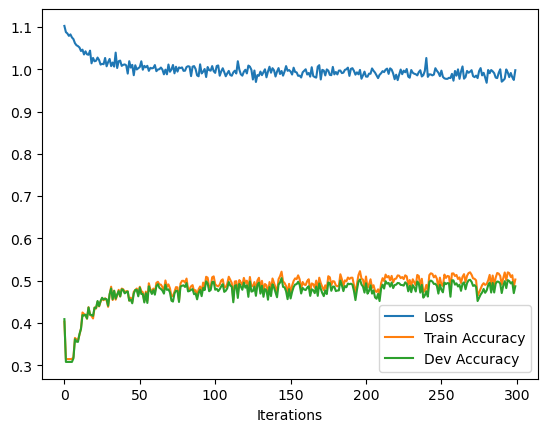

In [36]:
# Step 1: Load and preprocess your dataset
X_train = torch.tensor(Xmat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
soft_labels = torch.tensor(Y_soft_train, dtype=torch.float32)

# Step 2: Create an instance of the DistilledDAN model
num_classes = 3
embedding_dim = 50
hidden_dim1 = 256
hidden_dim2 = 64
hidden_dim3 = 32
leaky_relu_negative_slope = 0.1
dropout_probability = 0.3
model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, hidden_dim3, leaky_relu_negative_slope, dropout_probability)

# Step 3: Train the model using the `train_model` method
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_iterations = 3000
soft_label_weight = 1
loss_fn = nn.CrossEntropyLoss()
batch_size = 1000
check_every = 10
verbose = True

loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)

# Plot the training progress
import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(dev_accuracy, label='Dev Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [1]:
dev_accuracy

NameError: name 'dev_accuracy' is not defined

In [215]:
loss_fn(log_probs_batch, Y_batch)

tensor(1.1736, grad_fn=<NllLossBackward0>)

In [216]:
Y_batch = Y_train[0:10]

In [221]:
Y_batch

tensor([2, 0, 2, 1, 1, 1, 0, 1, 2, 2])

In [217]:
X_train_batch = X_train[0:10]

In [224]:
log_probs_batch

tensor([[7.1934e-02, 6.1714e-01, 3.1093e-01],
        [9.8872e-01, 1.1055e-02, 2.2412e-04],
        [1.7298e-01, 6.5338e-01, 1.7364e-01],
        [1.1245e-01, 3.8945e-01, 4.9810e-01],
        [2.7214e-03, 3.2602e-02, 9.6468e-01],
        [2.4449e-03, 3.8288e-02, 9.5927e-01],
        [2.5882e-02, 7.8515e-01, 1.8897e-01],
        [8.7644e-02, 1.9495e-01, 7.1741e-01],
        [1.2847e-02, 9.6496e-01, 2.2194e-02],
        [1.5724e-02, 1.2912e-02, 9.7136e-01]], grad_fn=<SoftmaxBackward0>)

In [218]:
log_probs_batch = model.forward(X_train_batch)

In [219]:
loss_fn(log_probs_batch, Y_batch)

tensor(1.1875, grad_fn=<NllLossBackward0>)

In [220]:
# Sample input and target tensors
logits = torch.tensor([[0.5, 1.0, 1.5], [1.0, 0.5, 1.5]], dtype=torch.float32)
targets = torch.tensor([0, 0], dtype=torch.long)

# Create the cross-entropy loss object
loss_fn = nn.CrossEntropyLoss()

# Compute the loss
loss = loss_fn(logits, targets)

print(f"Cross-entropy loss: {loss.item()}")

Cross-entropy loss: 1.430269718170166


In [144]:
# Sample one-hot encoded labels tensor
Y_batch_one_hot = torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=torch.float32)

# Convert one-hot encoded labels to class indices
Y_batch_indices = torch.argmax(Y_batch_one_hot, dim=1)

print(Y_batch_indices)

tensor([2, 0, 1])


# Grid Search to tune hyperparameters
Parameters to tune:
- learning rate
- dropout probability
- soft label weight
- number of layers (we will try two and three)


Notes for developer:

Store the iteration at which the highest accuracy occurs on each model

Store this in a table

Set global pytorch random seed for reproducibility 

Set global pytorch random seed for reproducibility 

In [3]:
torch.manual_seed(4)

NameError: name 'torch' is not defined

In [ ]:
# Step 1: Load and preprocess your dataset
X_train = torch.tensor(Xmat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
soft_labels = torch.tensor(Y_soft_train, dtype=torch.float32)


In [ ]:
def grid_search_student(hidden3=False):
    '''
    Performs a grid search to pick the combination of hyperparameters for the student
    Distilled Deep Averaging Network with the best accuracy on the task of sentiment analysis
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - loss function
    - number of iterations of gradient descent
    
    Hyper parameters:
    - learning rate [1e-5, 1e-4, 1e-3, 1e-2] 
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    - soft label weight [0.0, 0.2, 0.5, 0.4, 0.6, 0.8]
    - # of layers (2 or 3)
    - dropout on input layer
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    
    results = []
    best = {}
    best_dev_accuracy = 0
    
    # Hyperparameters
    learning_rates = [.00001, .0001, .001, .01]
    dropout_probs = [0.0, 0.2, 0.4, 0.6, 0.8]
    softlabel_weights = [0.0, 0.2, 0.5, 0.4, 0.6, 0.8]
    hidden_3 = [True, False]
    dropout_input = [True, False]
    batch_sizes = [500, 1000, 2000]
    
    # Fixed parameters, model architecture
    num_classes = 3
    embedding_dim = 50
    hidden_dim1 = 256
    hidden_dim2 = 64
    hidden_dim3 = 32
    leaky_relu_negative_slope = 0.1
    
    # Fixed parameters, model training
    num_iterations = 3000
    loss_fn = nn.CrossEntropyLoss()
    check_every = 10
    verbose = True
    
    # Grid Search
    for learning_rate in learning_rates:
        for dropout_prob in dropout_probs:
            for softlabel_weight in softlabel_weights:
                for is_hidden3 in hidden_3:
                    for is_dropout_input in dropout_input:
                        for batch_size in batch_sizes:
                        
                            # Create model
                            model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, hidden_dim3,
                                                 leaky_relu_negative_slope, dropout_prob, is_hidden3, is_dropout_input)

                            # Step 3: Train the model using the `train_model` method
                            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                            loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)
                            
                            best_iteration = argmax(dev_accuracy)
                            
                            result = {'train accuracies': train_accuracy, 'dev accuracies': dev_accuracy, 'best iteration': best_iteration, 'loss history': loss_history}
                            
                            if dev_accuracy(best_iteration) > best_dev_accuracy:
                                best_dev_accuracy = dev_accuracy(best_iteration)
                                best = result
                                
                            results.append(result)
    
    return results, best
    
    
def grid_search_baseline():
    '''
    Performs a grid search to pick the combination of hyperparameters for the Deep Averaging
    Network of the same architecture as the "student" with the best accuracy on the task of
    sentiment analysis.
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - soft label weight (set to 0)
    - learning rate
    - # of layers (2 or 3)
    
    Hyper parameters:
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    return [], {}